In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Compose
import os

In [2]:
degree = 3
n_nodes = 100
rate = 1.
T = 10
dt = 0.01
fprefix = 'data/rrg_sis_'

In [3]:
# Generating the network
graph = nx.random_regular_graph(2 * degree, n_nodes)
#graph = nx.barabasi_albert_graph(m=degree, n=n_nodes)
nx.write_edgelist(graph, fprefix + 't = dl.SIS_ToStructuredData()edgelist.b')

# Generating the time series
continue_simu = False
iter_max = 100
i = 0
num_sample = 10000

#if os.path.exists(fprefix + '_states.b'):
#    os.remove(fprefix + '_states.b')
data = {}
idx = 0
while(i < num_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < num_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + '_states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [4]:
transform = [dl.SIS_StateToFloat()]

dataset = dl.Markov_Dataset(fprefix + '_states.b', pre_transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])

In [5]:
n_hidden = [1024,1024]
n_embedding = 800
optimizer = lambda p: torch.optim.Adam(p, lr=1e-2, weight_decay=1e-3)
use_cuda = False

markov_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

In [6]:
new_lr = 1e-3
for g in markov_cvae.optimizer.param_groups:
    g['lr'] = new_lr

In [7]:
markov_cvae.fit(train_dataset, val_dataset, epochs=50, batch_size=128)

Epoch 0 - Training Loss: 49.1529 ± 1.01 - Validation Loss: 48.8256 ± 0.88 - Training time: 8.9466 - New best
Epoch 1 - Training Loss: 31.2082 ± 0.65 - Validation Loss: 31.4564 ± 0.34 - Training time: 9.4722 - New best
Epoch 2 - Training Loss: 19.5078 ± 0.55 - Validation Loss: 20.1413 ± 0.54 - Training time: 11.1547 - New best
Epoch 3 - Training Loss: 14.6547 ± 0.56 - Validation Loss: 15.2427 ± 0.45 - Training time: 11.1310 - New best
Epoch 4 - Training Loss: 12.3923 ± 0.58 - Validation Loss: 13.0461 ± 0.46 - Training time: 10.1449 - New best
Epoch 5 - Training Loss: 11.1763 ± 0.63 - Validation Loss: 11.8093 ± 0.36 - Training time: 9.4842 - New best
Epoch 6 - Training Loss: 10.2636 ± 0.56 - Validation Loss: 11.1043 ± 0.38 - Training time: 9.6549 - New best
Epoch 7 - Training Loss: 10.5198 ± 0.61 - Validation Loss: 11.4915 ± 0.53 - Training time: 8.5690 - 
Epoch 8 - Training Loss: 9.4452 ± 0.65 - Validation Loss: 10.3722 ± 0.48 - Training time: 7.9248 - New best
Epoch 9 - Training Loss: 

In [10]:
def test_model(learned_model, dataset):
    init_states = dataset[0][0]
    #T = len(dataset)
    t = 0
    learned_states, z, passed_states = learned_model.predict(init_states, batch_size=2)
    learned_avg = [np.mean(learned_states)]
    while(t < T):
        t += dt
        
        learned_states, z, passed_states = learned_model.predict(passed_states, batch_size=2)
        learned_states = torch.bernoulli(torch.tensor(learned_states[0]))
        passed_states = learned_states
        learned_avg.append(np.mean(learned_states.numpy()))
    
    return learned_avg

def show_dataset(dataset):
    avg = []
#     for i in range(len(dataset)):
#         x = dataset[i][0].numpy()
#         avg.append(np.mean(x))
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [11]:
null_cvae = dl.Markov_Complete_CVAE(n_nodes, n_hidden, n_embedding, optimizer=optimizer, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
null_ts = test_model(null_cvae, dataset)
trained_ts = test_model(markov_cvae, dataset)


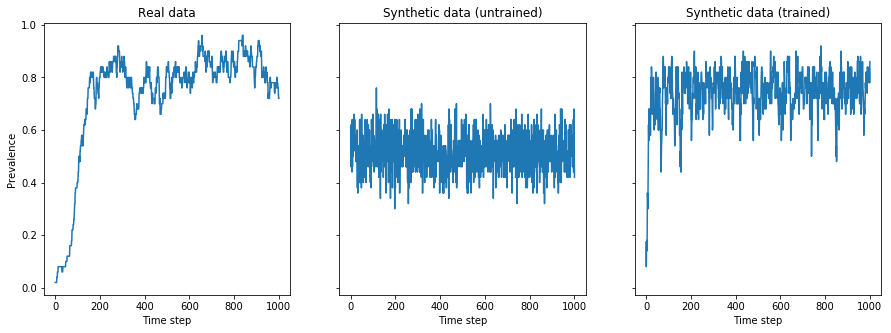

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(null_ts)
ax[1].set_title('Synthetic data (untrained)')
ax[1].set_xlabel('Time step')

ax[2].plot(trained_ts)
ax[2].set_title('Synthetic data (trained)')
ax[2].set_xlabel('Time step')

#fig.savefig(f'fig/png/naive_rrgsis_d{degree}_n{n_nodes}_rate{rate}.png')
#fig.savefig(f'fig/pdf/naive_rrgsis_d{degree}_n{n_nodes}_rate{rate}.pdf')
plt.show()